# Imports

In [2]:
import pandas as pd
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

# Data Load

In [3]:
# Load the Uber Request Data

uber_data = pd.read_csv('Uber Request Data.csv')

# Explore Data

In [3]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB


You can notice nulls in columns "Driver id" and "Drop timestamp". These need not be handled as they are not used in the analysis and are going to be dropped from the data set.

In [4]:
uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


We can see that the date time format in the Request timestamp column is not consistent. This will be handled below to bring all the values to a single date time format for the ease of future analysis.

# Data Formatting

In [5]:
uber_data['Request timestamp'] = uber_data['Request timestamp'].apply(lambda x: str(x).replace('/','-'))

Replaced '/' with '-' for uniformity.

In [6]:
uber_data['Request timestamp'] = uber_data['Request timestamp'].apply(lambda x: str(x)+':00' if str(x).count(':') == 1 else str(x))

Imputing the seconds value of some timestamps where it is missing to 00 seconds.

In [7]:
uber_data['Request timestamp'] = uber_data['Request timestamp'].apply(lambda x: datetime.strptime(str(x), "%d-%m-%Y %H:%M:%S"))

Bringing column values to single format "%d-%m-%Y %H:%M:%S"

In [8]:
# Examining the data post processing

uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,13-07-2016 09:25:47


In [9]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null datetime64[ns]
Drop timestamp       2831 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 316.2+ KB


# Dervied Metric(s)

In [10]:
# Extract hour from the date to analyze the supply/demand at each hour of a typical day in the data set.

uber_data['Request Hour'] = uber_data['Request timestamp'].dt.hour

In [11]:
# Create new column Gap which helps during the analysis

uber_data['Supply'] = uber_data['Status'].apply(lambda x: 1 if x == 'Trip Completed' else 0)

uber_data['Gap'] = uber_data['Status'].apply(lambda x: 'No' if x == 'Trip Completed' else 'Yes')

In [12]:
# Create new column Time Slot which helps during the analysis

TIME_SLOTS = {
    0: 'Late Night',
    1: 'Midnight',
    2: 'Midnight',
    3: 'Early Morning',
    4: 'Early Morning',
    5: 'Early Morning',
    6: 'Morning',
    7: 'Morning',
    8: 'Morning',
    9: 'Morning',
    10: 'Morning',
    11: 'Morning',
    12: 'After Noon',
    13: 'After Noon',
    14: 'After Noon',
    15: 'After Noon',
    16: 'Evening',
    17: 'Evening',
    18: 'Evening',
    19: 'Night',
    20: 'Night',
    21: 'Night',
    22: 'Late Night',
    23: 'Late Night',
}

uber_data['Time Slot'] = uber_data['Request Hour'].apply(lambda x: TIME_SLOTS.get(x))

In [13]:
# Supply and Demand numbers for analysis

gap_count = pd.DataFrame(index=[0], columns=['Request Hour','Supply','Demand','Gap Count']).dropna()

gap_count['Request Hour'] = uber_data.pivot_table(values = 'Supply', index = 'Request Hour', aggfunc = sum).index

gap_count['Supply'] = uber_data.pivot_table(values = 'Supply', index = 'Request Hour', aggfunc = sum)['Supply']

gap_count['Demand'] = uber_data.pivot_table(values = 'Status', index = 'Request Hour', aggfunc = len)['Status']

gap_count['Gap Count'] = gap_count['Demand'] - gap_count['Supply']

# Data Cleanup

In [14]:
# Dropping columns that are not required for the current analysis

uber_data = uber_data.drop(columns=['Drop timestamp','Request timestamp','Supply','Driver id','Request id'])

# Data Verification

In [15]:
uber_data.head()

,Pickup point,Status,Request Hour,Gap,Time Slot
0,Airport,Trip Completed,11,No,Morning
1,Airport,Trip Completed,17,No,Evening
2,City,Trip Completed,9,No,Morning
3,Airport,Trip Completed,21,No,Night
4,City,Trip Completed,8,No,Morning


In [16]:
# Validating if the numbers are correct against the original data set count

gap_count['Demand'].sum() 

6745

# Data Segmentation

In [17]:
# Data frame that contains data pertaining to all unfulfilled requests => Cancellation or Unavailability

uber_gap = uber_data.loc[(uber_data['Status'] == 'No Cars Available') | (uber_data['Status'] == 'Cancelled')]

# Data frame that contains data pertaining to fulfilled requests => Trip completed

uber_supply = uber_data.loc[uber_data['Status'] == 'Trip Completed']

# Data frames taht contain data pertaining to fulfilled requests that have drop/pickup location as Airport respectively

uber_supply_airport_inflow = uber_supply.loc[uber_supply['Pickup point'] == 'City']
uber_supply_airport_outflow = uber_supply.loc[uber_supply['Pickup point'] == 'Airport']

# Other data frames with segmented information for airport & city like Cancelled data, No cars available data and 
# Trip complete data etc

uber_cancelled = uber_data.loc[uber_data['Status'] == 'Cancelled']
uber_nocar = uber_data.loc[uber_data['Status'] == 'No Cars Available']

uber_cancelled_aiport = uber_data.loc[(uber_data['Status'] == 'Cancelled') & (uber_data['Pickup point'] == 'Airport')]
uber_cancelled_city = uber_data.loc[(uber_data['Status'] == 'Cancelled') & (uber_data['Pickup point'] == 'City')]

uber_nocar_aiport = uber_data.loc[(uber_data['Status'] == 'No Cars Available') & (uber_data['Pickup point'] == 'Airport')]
uber_nocar_city = uber_data.loc[(uber_data['Status'] == 'No Cars Available') & (uber_data['Pickup point'] == 'City')]

uber_tripcomplete_aiport = uber_data.loc[(uber_data['Status'] == 'Trip Completed') & (uber_data['Pickup point'] == 'Airport')]
uber_tripcomplete_city = uber_data.loc[(uber_data['Status'] == 'Trip Completed') & (uber_data['Pickup point'] == 'City')]

# Most pressing problems for Uber

### Frequency of requests that get cancelled or show 'no cars available'

In [18]:
# Distinct status counts to be matched with the plot data below

uber_data['Status'].value_counts()

Trip Completed       2831
No Cars Available    2650
Cancelled            1264
Name: Status, dtype: int64

### Choice of plots in the analysis that follows

Count Plot => Used to plot segmented categorical data along with their frequencies or counts like the pickup point data across various hours of the day to show the contrinution by each of them.

Dist Plot => Used to plot density of a categorical variable like how the car inflow/outflow to/from the airport looks like to identify the time slots where there is inflow to airport or vice versa.

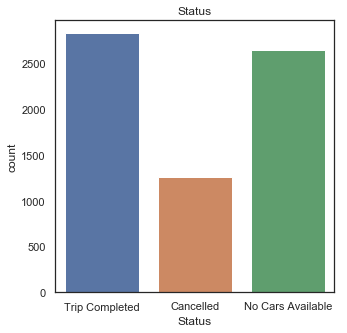

In [19]:
# Below plot shows the frequency of requests across different Status

plt.figure(figsize=(5,5))
plt.title('Status')
sns.countplot(x="Status", data=uber_data)
plt.show()

### Most problematic types of requests

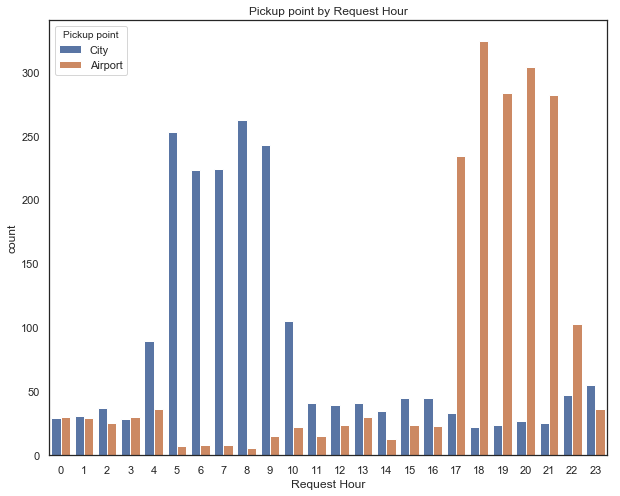

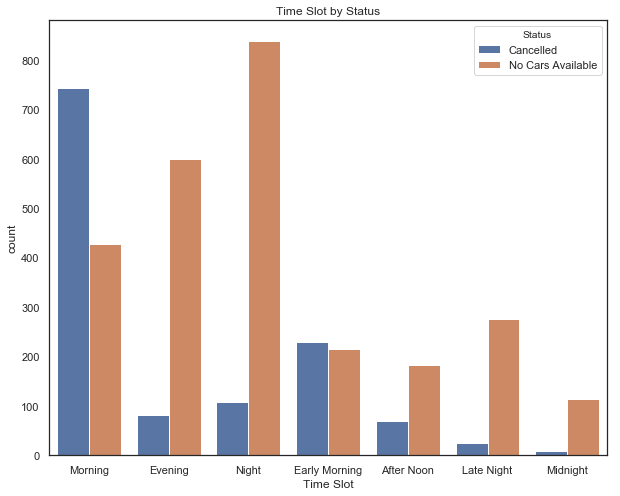

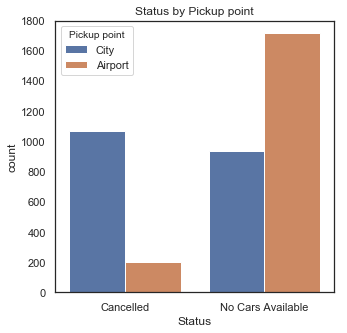

In [20]:
# Pickup point by Request Hour was chosen from Gap data frame to show which specific pickup point contributes to the
# high demand at which request hours

plt.figure(figsize=(10,8))
plt.title('Pickup point by Request Hour')
sns.countplot(x="Request Hour", hue="Pickup point", data=uber_gap)
plt.show()

# Time Slot by Status was chosen from Gap data frame to show which specific time slot contributes to the
# cancellations/no cars available problems

plt.figure(figsize=(10,8))
plt.title('Time Slot by Status')
sns.countplot(x="Time Slot", hue="Status", data=uber_gap)
plt.show()

# Pickup point by Status was chosen from Gap data frame to show which pickup point contributes to the supply-demand gap

plt.figure(figsize=(5,5))
plt.title('Status by Pickup point')
sns.countplot(x="Status", hue="Pickup point", data=uber_gap)
plt.show()

### Inference

We can infer the below from the plots shown above:

1) Cab cancellations are relatively more when the request is from city to airport and the time slot in which this is happening is 4 AM to 10 AM i.e., in the early morning and morning time slots.

2) No cars available are relatively more when the request is from airport to city and the time slot in which this is happening is 5 PM to 10 PM i.e., in the evening and the night time slots.

# Gap between supply and demand

### Numbers never lie

In [21]:
# Examining the supply and demand numbers to verify against the next plot for each request hour

gap_count

,Request Hour,Supply,Demand,Gap Count
0,0,40,99,59
1,1,25,85,60
2,2,37,99,62
3,3,34,92,58
4,4,78,203,125
5,5,185,445,260
6,6,167,398,231
7,7,174,406,232
8,8,155,423,268
9,9,173,431,258


Supply is defined as any request with status "Trip Completed"

Demand is all the requests

Gap is defined as any request with status either "Cancelled" or "No Cars Available"

### Time slots when the highest gap exists

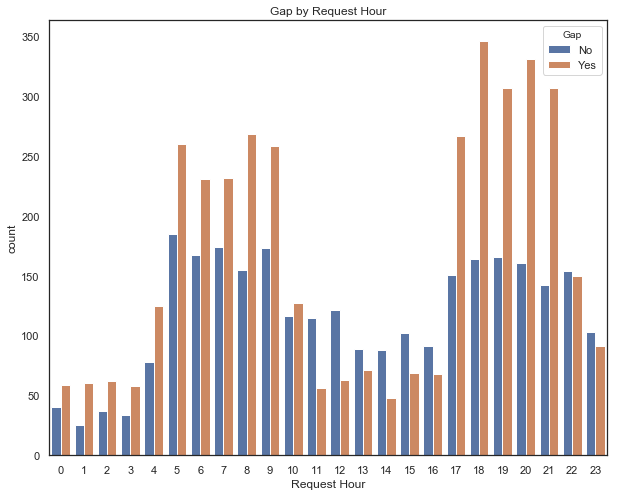

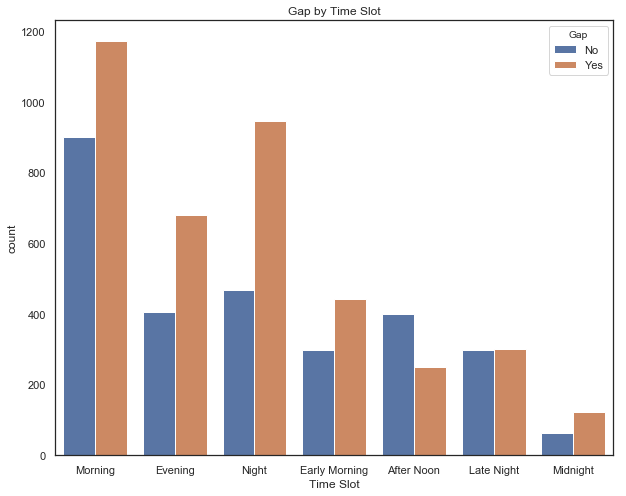

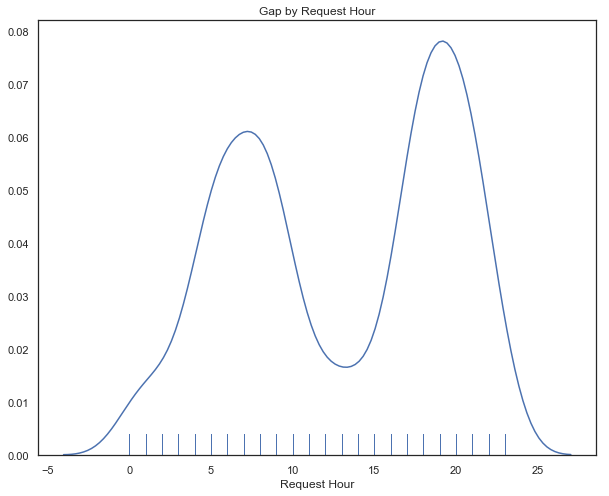

In [22]:
# Request hour by Gap from overall data was chosen to analyze which request hours are contributing to the supply-demand gap

plt.figure(figsize=(10,8))
plt.title('Gap by Request Hour')
sns.countplot(x="Request Hour", hue="Gap", data=uber_data)
plt.show()

# Time Slot by Gap from overall data was chosen to analyze which time slots are contributing to the supply-demand gap

plt.figure(figsize=(10,8))
plt.title('Gap by Time Slot')
sns.countplot(x="Time Slot", hue="Gap", data=uber_data)
plt.show()

# Same as above but with distribution plot

plt.figure(figsize=(10,8))
plt.title('Gap by Request Hour')
sns.distplot(uber_gap['Request Hour'], rug=True, hist=False)
plt.show()

Clearly, the highest gap exists in time slots 4 AM to 10 AM and 5 PM to 10 PM i.e., early morning, morning, evening and night time slots.

### Types of requests for which the gap is the most 

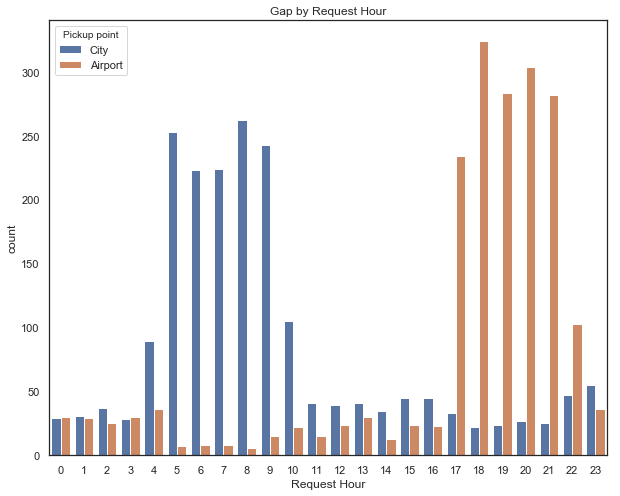

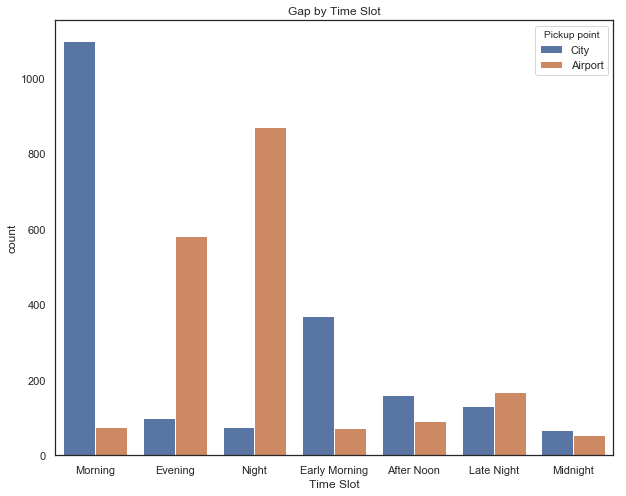

In [23]:
# Request hour by Pickup point from Gap data fame to analyze which pickup points contribute to the supply-demand gap

plt.figure(figsize=(10,8))
plt.title('Gap by Request Hour')
sns.countplot(x="Request Hour", hue="Pickup point", data=uber_gap)
plt.show()

plt.figure(figsize=(10,8))
plt.title('Gap by Time Slot')
sns.countplot(x="Time Slot", hue="Pickup point", data=uber_gap)
plt.show()

We can infer the below from the plots shown above:

1) In the time slot 4 AM to 10 AM i.e., early morning and morning time slots, supply-demand gap is high for requests to airport from city.

2) In the time slot 5 PM to 10 PM i.e., evening and night time slots, supply-demand gap is high for request to city from airport.

# Reason for Supply-Demand Gap

### Supply Plots

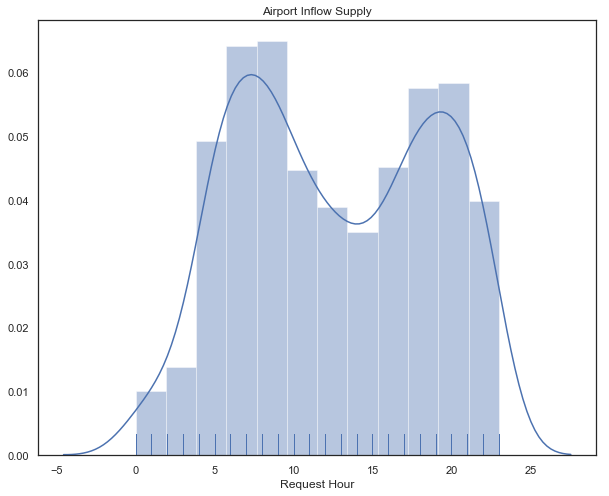

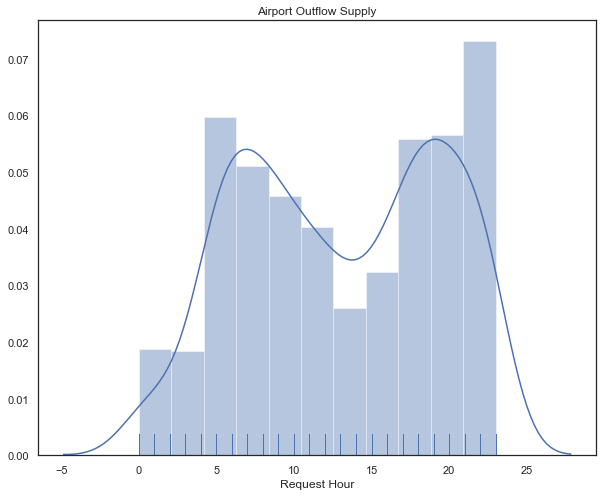

In [24]:
# Plot Airport inflow for finding the distribution of cars towards airport across the day

plt.figure(figsize=(10,8))
plt.title('Airport Inflow Supply')
sns.distplot(uber_supply_airport_inflow['Request Hour'], rug=True)
plt.show()

# Plot Airport outflow for finding the distribution of cars from airport across the day

plt.figure(figsize=(10,8))
plt.title('Airport Outflow Supply')
sns.distplot(uber_supply_airport_outflow['Request Hour'], rug=True)
plt.show()

### Demand Plots

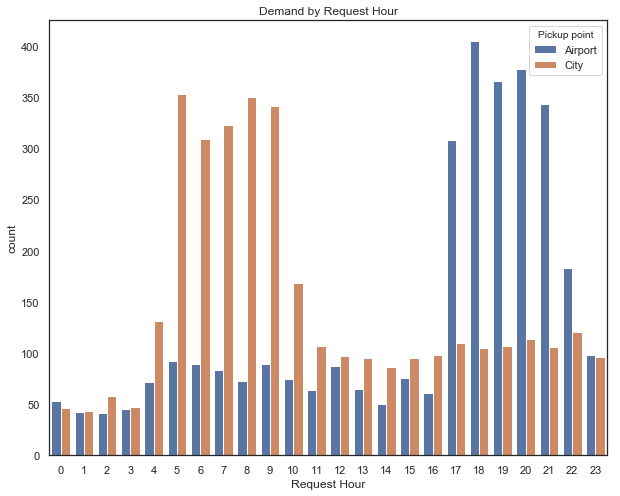

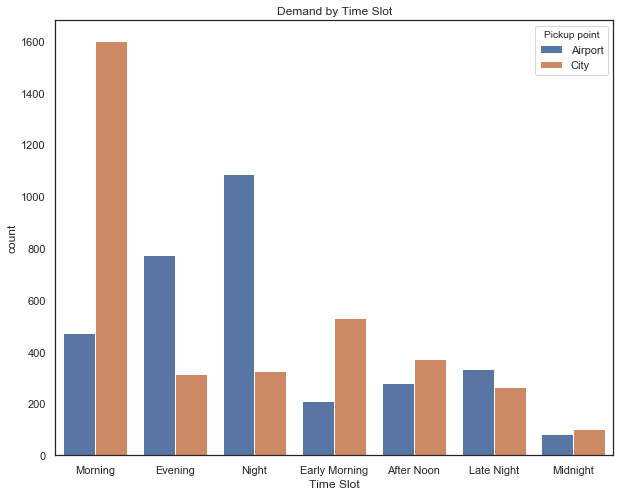

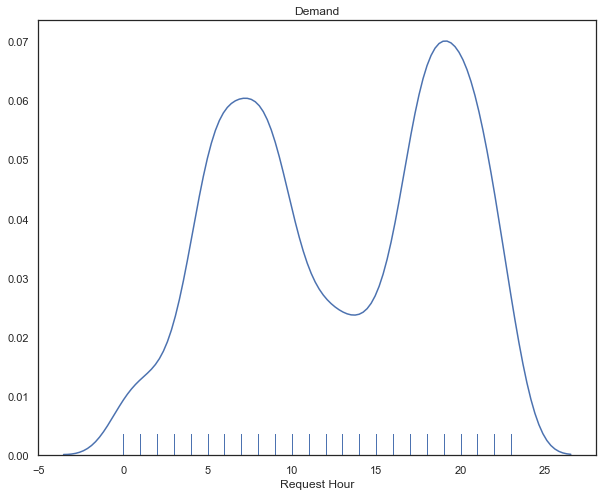

In [25]:
# Plots to show demand of cars across the day at various hours/time slots

plt.figure(figsize=(10,8))
plt.title('Demand by Request Hour')
sns.countplot(x="Request Hour", hue="Pickup point", data=uber_data)
plt.show()

plt.figure(figsize=(10,8))
plt.title('Demand by Time Slot')
sns.countplot(x="Time Slot", hue="Pickup point", data=uber_data)
plt.show()

plt.figure(figsize=(10,8))
plt.title('Demand')
sns.distplot(uber_data['Request Hour'], rug=True, hist=False)
plt.show()

### Supply-Demand Gap Plots

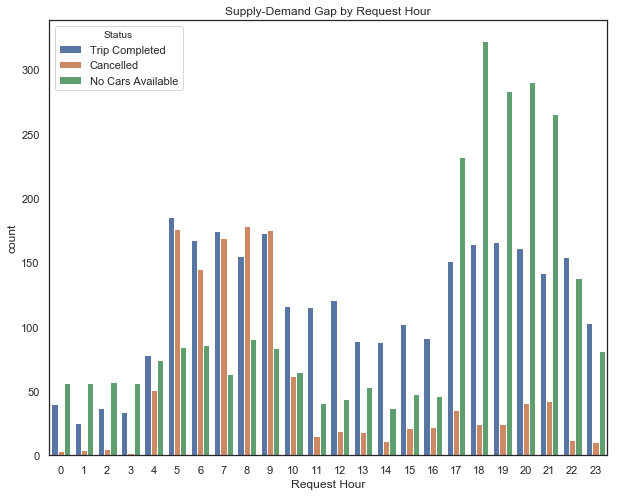

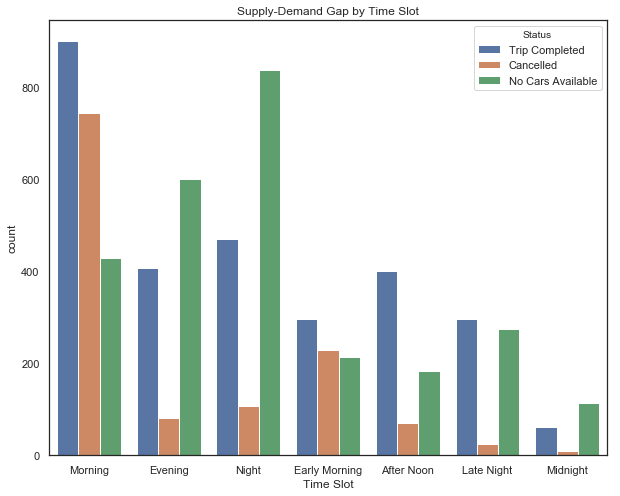

In [26]:
# Putting in all together from the data overall data set which shows supply (Trip Completed), demand (Cancellation
# /No Car) and gap

plt.figure(figsize=(10,8))
plt.title('Supply-Demand Gap by Request Hour')
sns.countplot(x="Request Hour", hue="Status", data=uber_data)
plt.show()

plt.figure(figsize=(10,8))
plt.title('Supply-Demand Gap by Time Slot')
sns.countplot(x="Time Slot", hue="Status", data=uber_data)
plt.show()

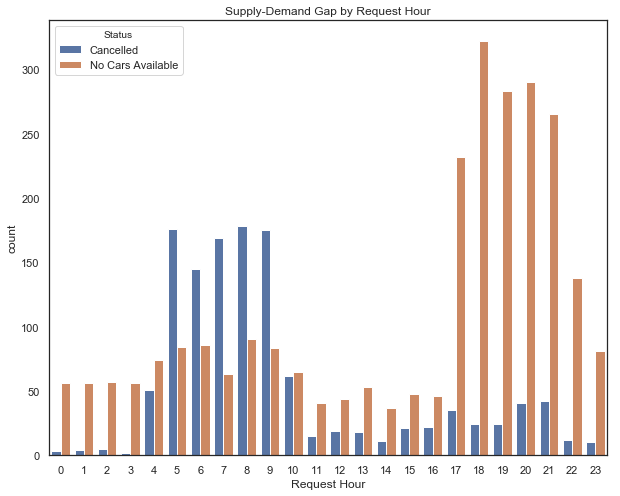

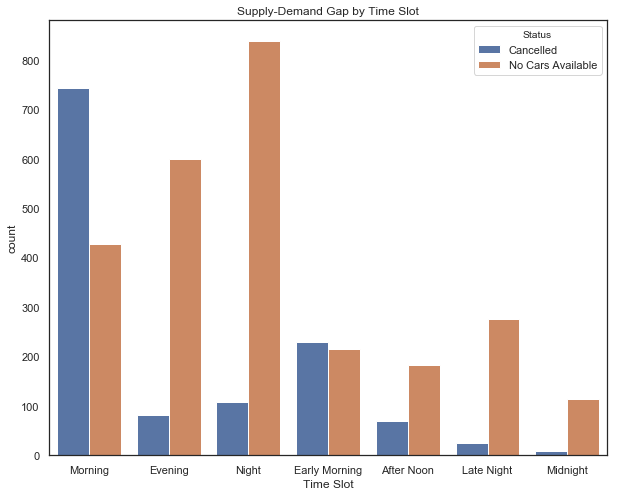

In [27]:
# Same as above but the data considered is the Gap data

plt.figure(figsize=(10,8))
plt.title('Supply-Demand Gap by Request Hour')
sns.countplot(x="Request Hour", hue="Status", data=uber_gap)
plt.show()

plt.figure(figsize=(10,8))
plt.title('Supply-Demand Gap by Time Slot')
sns.countplot(x="Time Slot", hue="Status", data=uber_gap)
plt.show()

Both "Car Cancellations" from 4 AM to 10 AM and "No Cars Available" from 5 PM to 10 PM are pressing problems for Uber.

1) Car cancellations being more from 4 AM to 10 AM could be due to the fact that the airport doesn't have more arrivals in the same time slot and also till 5 PM there by less number of requests from airport to city. Hence drivers don't want to get stranded at the airport without any requests for a long time which could be used to earn more money if they were in city.

2) No cars available being more from 5 PM to 10 PM could be due to the fact that the airport doesn't have more departures in the same time slot and also till 4 AM there by causing less inflow to airport causing not many cars available at the airport. This could also be due to the time of the day which is when the working hours end for most of the drivers.

# Additional Plots for EDA

### Cancelled Requests

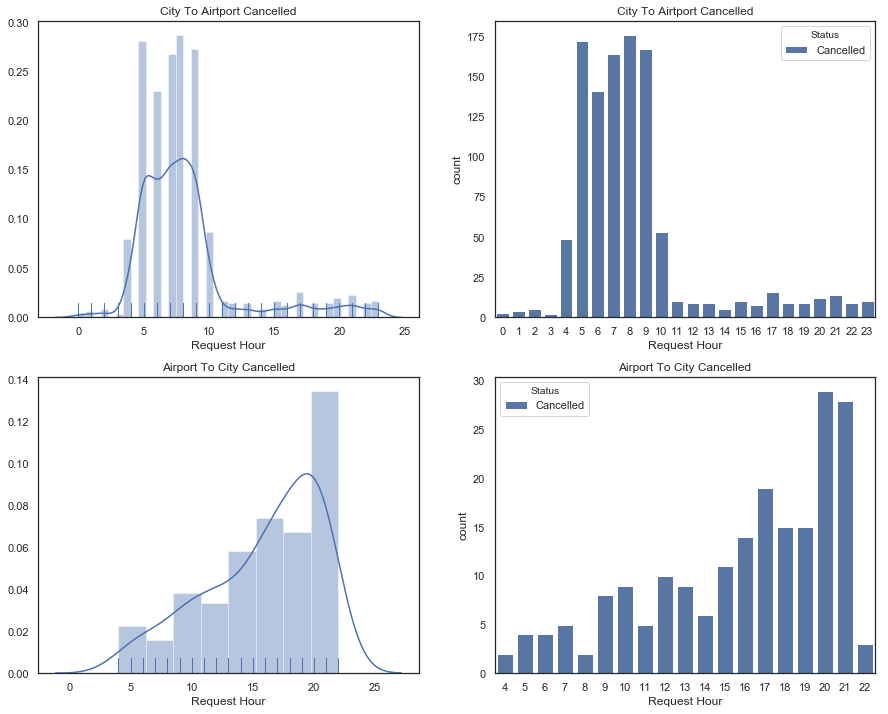

In [28]:
# figure size
plt.figure(figsize=(15,12))

# subplot 1
plt.subplot(2, 2, 1)
plt.title('City To Airtport Cancelled')
sns.distplot(uber_cancelled_city['Request Hour'], rug=True)

# subplot 2
plt.subplot(2, 2, 2)
plt.title('City To Airtport Cancelled')
sns.countplot(x="Request Hour", hue="Status", data=uber_cancelled_city)

# subplot 3
plt.subplot(2, 2, 3)
plt.title('Airport To City Cancelled')
sns.distplot(uber_cancelled_aiport['Request Hour'], rug=True)

# subplot 4
plt.subplot(2, 2, 4)
plt.title('Airport To City Cancelled')
sns.countplot(x="Request Hour", hue="Status", data=uber_cancelled_aiport)

plt.show()

Clearly, city to airport cancellations are standing out between 4 AM to 10 AM i.e, early morning and morning time slots and airport to city cancellations are showing spike at 8 and 9 PM i.e., in the night time slot.

### No Cars Available Requests

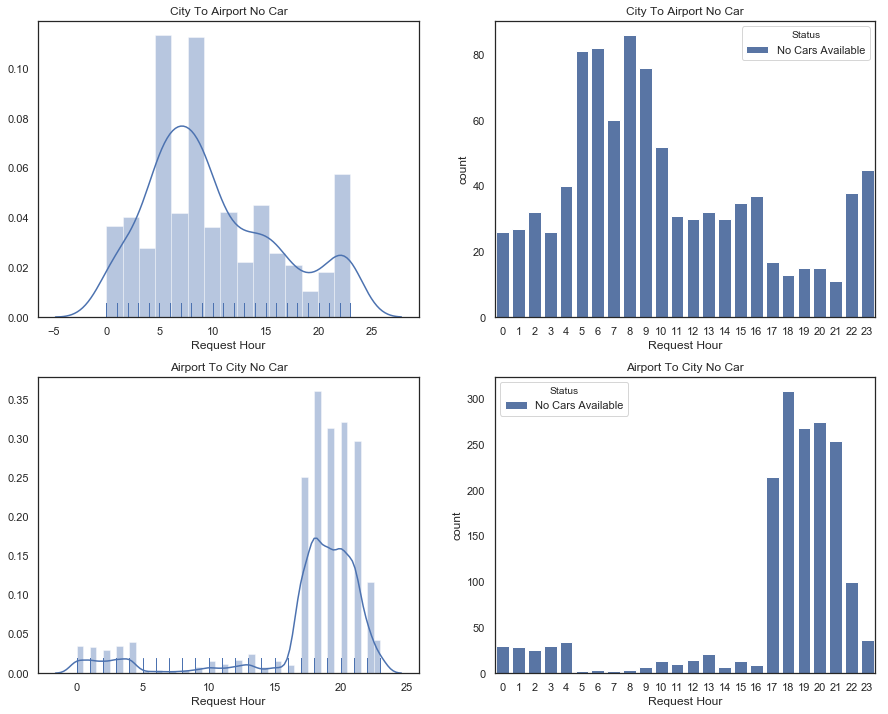

In [29]:
# figure size
plt.figure(figsize=(15,12))

# subplot 1
plt.subplot(2, 2, 1)
plt.title('City To Airport No Car')
sns.distplot(uber_nocar_city['Request Hour'], rug=True)

# subplot 2
plt.subplot(2, 2, 2)
plt.title('City To Airport No Car')
sns.countplot(x="Request Hour", hue="Status", data=uber_nocar_city)

# subplot 3
plt.subplot(2, 2, 3)
plt.title('Airport To City No Car')
sns.distplot(uber_nocar_aiport['Request Hour'], rug=True)

# subplot 4
plt.subplot(2, 2, 4)
plt.title('Airport To City No Car')
sns.countplot(x="Request Hour", hue="Status", data=uber_nocar_aiport)

plt.show()

Clearly, airport to city no cars available are standing out between 5 PM to 10 PM i.e, evening and night time slots and airport to city no cars available are showing spike 4 AM and 10 AM i.e., in the early morning and morning time slots.

### Trip Completed Requests

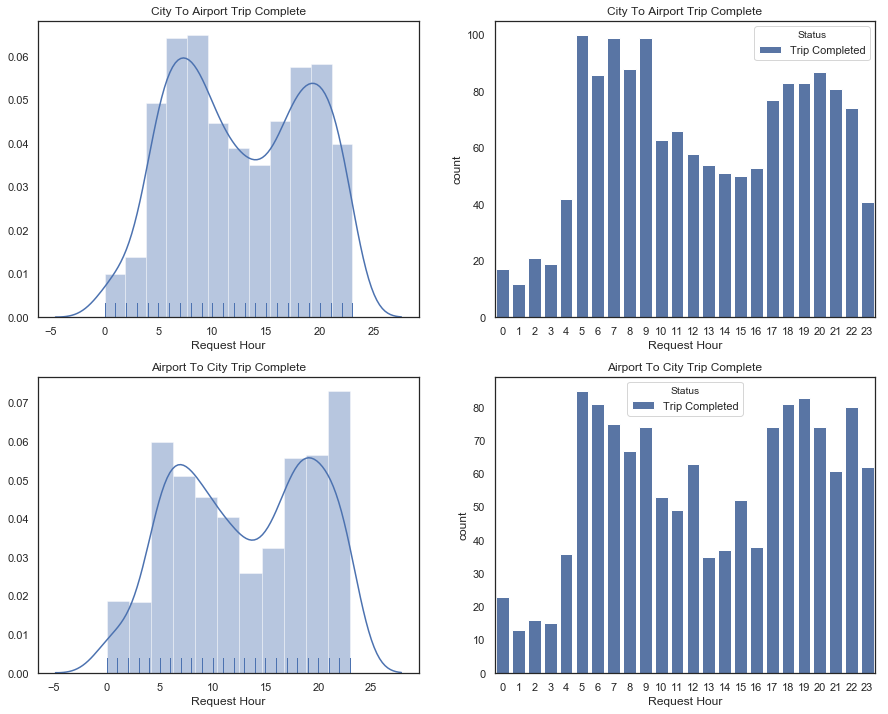

In [30]:
# figure size
plt.figure(figsize=(15,12))

# subplot 1
plt.subplot(2, 2, 1)
plt.title('City To Airport Trip Complete')
sns.distplot(uber_tripcomplete_city['Request Hour'], rug=True)

# subplot 2
plt.subplot(2, 2, 2)
plt.title('City To Airport Trip Complete')
sns.countplot(x="Request Hour", hue="Status", data=uber_tripcomplete_city)

# subplot 3
plt.subplot(2, 2, 3)
plt.title('Airport To City Trip Complete')
sns.distplot(uber_tripcomplete_aiport['Request Hour'], rug=True)

# subplot 4
plt.subplot(2, 2, 4)
plt.title('Airport To City Trip Complete')
sns.countplot(x="Request Hour", hue="Status", data=uber_tripcomplete_aiport)

plt.show()